# Idea

Use keras resenet encoder, then custom decoder. Group together to form siamese triplets, with a stack of the three decoded features. Then minimize the distance between the three.

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

Mount the google drive with uploaded input data

In [8]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
path_to_folder = "/content/drive/MyDrive/IML_Task3/"

Mounted at /content/drive


# Data Loading (JONNY)
First create a dataset containing only the number triplets

In [ ]:
# resnet input dimensions 224 x 224 x 3
# efficient net input size 256
IMG_HEIGHT = 256
IMG_WIDTH = 256
TRAIN_DATASET_SIZE = 0 # gets overwritten in load_dataset
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
# TODO move these paths down
path_to_train = path_to_folder + "train_triplets.txt"
path_to_test = path_to_folder + "test_triplets.txt"
path_to_food = path_to_folder + "food/"

def load_image(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32)
    img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    return img

def get_image_triplet(num_triplet, is_train):
  imA = load_image(tf.io.read_file(path_to_food + num_triplet[0] + '.jpg'))
  imB = load_image(tf.io.read_file(path_to_food + num_triplet[1] + '.jpg'))
  imC = load_image(tf.io.read_file(path_to_food + num_triplet[2] + '.jpg'))
  # in training append label = 1
  if is_train:
    return tf.stack([imA, imB, imC], axis=0), 1
  else:
    return tf.stack([imA, imB, imC], axis=0)

def load_dataset(path, is_train):
  data_array = np.loadtxt(path, dtype=str)
  dataset = tf.data.Dataset.from_tensor_slices(data_array) # num1 num2 num3 as string
  # apply transformation to images
  dataset = dataset.map(lambda num_triplet: get_image_triplet(num_triplet, is_train),
      num_parallel_calls=AUTOTUNE)
  dataset = dataset.batch(32)
  return dataset

## Loading the datasets
Load the train, validation and test datasets, with a split of 80%/20% for the validation

worked so far


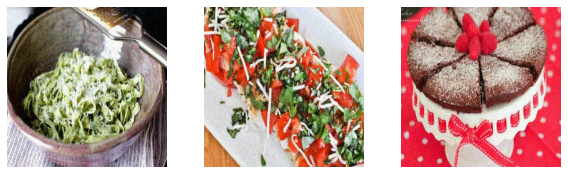

In [9]:
# functions to split the dataset into train and validation, as we are using map
TRAIN_VALID_SPLIT = 0.8

def is_valid(idx, value):
    # used for filter, returns true for every fifth element
    return idx % 5 == 0

def is_train(idx, value):
    # used for filter, returns false for every fifth element
    return not is_valid(idx, value)

recover_value = lambda idx, value: value

with tf.device('/device:GPU:0'):
  full_train_dataset = load_dataset(path_to_train, is_train=True)
  val_dataset = full_train_dataset.enumerate().filter(is_valid).map(recover_value)
  train_dataset = full_train_dataset.enumerate().filter(is_train).map(recover_value)

  test_dataset = load_dataset(path_to_test, is_train=False)
  print("worked so far")
for batch in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  images = batch[0][0]
  for i in range(3):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i] / 255)
    plt.axis('off')

Use buffered prefetching to remove I/O bottleneck in image loading

In [10]:
print(f"type train dataset: {type(train_dataset)}")
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

type train dataset: <class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>


To avoid overfitting and enhance the dataset we introduce data augmentation during training by randomly flipping and rotating the images. This layer is automatically only active during training

In [ ]:
data_augm_layer = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

We also need to preprocess the images to bring them into the correct format, although **for Efficient net, this is not required** as the preprocessing layer is part of the model already. For Resnet we would use:

In [ ]:
# preproc_layer = tf.keras.applications.resnet.preprocess_input 

# Creating The Model (LASSE UND ADRIAN)

The model should have a pretrained encoder, apply them to all three images and stich them together with custom layers. ADRIAN AND LASSE

In [27]:
class model_manager:
    def __init__(self,img_height,img_width):
        self.IMG_HEIGHT = img_height
        self.IMG_WIDTH = img_width
        self.inputs = tf.keras.Input(shape=(3, self.IMG_HEIGHT, self.IMG_WIDTH, 3))
        #create data augmentation by randomly switching horizontally and randomly rotate by 0.1
        data_augmentation = tf.keras.Sequential(
            [
                tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
                tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
            ]
        )
        #EfficientNet does not need preprocessing and expects inputs in tensor form in the range 0-255
        encoder =  tf.keras.applications.EfficientNetB4(
            include_top=False, input_shape=(self.IMG_HEIGHT, self.IMG_WIDTH, 3), 
            weights="imagenet")
        encoder.trainable = False
        decoder = tf.keras.Sequential([
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(128),
            tf.keras.layers.Lambda(
                lambda t: tf.math.l2_normalize(t, axis=1))
        ])
        image, similar, different = self.inputs[:, 0, ...], self.inputs[:, 1, ...], self.inputs[:, 2, ...]
        image_features = decoder(encoder(data_augmentation(image)))
        similar_features = decoder(encoder(data_augmentation(similar)))
        different_features = decoder(encoder(data_augmentation(different)))
        self.out_features = tf.stack([image_features,similar_features,different_features],axis=-1)
        self.model = tf.keras.Model(inputs=self.inputs,outputs=self.out_features)
        print("Successfully built basic model!")

    def calc_difference(self):
        '''Compute the difference between the considered image and the alledged 
        similar and different one respectively. Returns two positive numbers'''
        image = self.out_features[...,0]
        similar = self.out_features[...,1] 
        different = self.out_features[...,2]
        # sum of squared differences
        sim_diff = tf.reduce_sum(tf.square(image - similar),1)
        dif_diff = tf.reduce_sum(tf.square(image - different),1)
        return sim_diff, dif_diff

    def triplet_loss_function(self,_):
            '''loss function to minimize during back propagation\n
                Apparently one has to define a loss function with y_true and y_pred as arguments and this is the easiest way..'''
            sim_diff, dif_diff = self.calc_difference()
            def loss(y_true,y_pred):
            #consider the cases where sim_diff is significantly higher than dif_diff
              return tf.reduce_mean(tf.math.softmax(sim_diff-dif_diff))
            return loss

    def compile(self):
        print("Compilation Initiated...")
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                            loss=self.triplet_loss_function,
                            metrics=self.triplet_loss_function)
        print("NN compiled successfully!")

    def fit(self,_train_ds, _valid_ds,  _epochs=1, _batch_size=32,_verbose=1):
        #59515 being the length of the training samples
        print(f"Batch size: {_batch_size}")
        print(f"Epochs: {_epochs}")
        print(f"Steps: {np.ceil(47612/_batch_size)-1}")
        print(f"Starting fitting procedure...")
        self.model.fit(_train_ds,batch_size=_batch_size, epochs=_epochs,validation_data=_valid_ds,verbose=_verbose, steps_per_epoch=int(np.ceil(59515*0.8/_batch_size)-1))
        print(f"Fitting procedure finished!")

    def add_predictor(self):
        sim_diff, dif_diff = self.calc_difference(self.out_features)
        prediction = tf.cast(tf.greater_equal(dif_diff,sim_diff),np.int8)
        self.model = tf.keras.model(inputs=self.input,outputs=prediction)

# Main

In [29]:
if __name__ == "__main__":
  with tf.device('/device:GPU:0'):
    manager = model_manager(256,256)
    #manager.compile()
    #manager.fit(train_dataset, val_dataset)
    #check for saved model or create new 
    if(os.path.isdir(path_to_folder + "model_2")):
      model = tf.keras.models.load_model(path_to_folder + "model_2",custom_objects={'triplet_loss_function' : manager.triplet_loss_function(_)})
      manager.model = model
      print("Successfully loaded model!!!!")
      manager.model.summary()
    else:
      manager.compile()
      manager.fit(train_dataset, val_dataset)
      manager.model.save(path_to_folder + "model_2")

    manager.add_predictor()
    #sim_diff, dif_diff = manager.calc_difference(manager.out_features)
    #prediction = tf.cast(tf.greater_equal(dif_diff,sim_diff),np.int8)
    #manager.model = tf.keras.model(inputs=manager.input,outputs=prediction)
    predictions = manager.model.predict(test_dataset,verbose=1)
    np.savetxt(path_to_folder + 'predictions.txt', predictions,fmt='%i')

Successfully built basic model!
Successfully loaded model!!!!
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 3, 256, 256  0           []                               
                                , 3)]                                                             
                                                                                                  
 tf.__operators__.getitem_12 (S  (None, 256, 256, 3)  0          ['input_9[0][0]']                
 licingOpLambda)                                                                                  
                                                                                                  
 tf.__operators__.getitem_13 (S  (None, 256, 256, 3)  0          ['input_9[0][0]']                
 licingOpLambda)              

TypeError: ignored

In [19]:
#Trying splitting class into individual functions in order to surpass loss_fct problem
def build_model(IMG_HEIGHT,IMG_WIDTH):
      inputs = tf.keras.Input(shape=(3, IMG_HEIGHT, IMG_WIDTH, 3))
      #create data augmentation by randomly switching horizontally and randomly rotate by 0.1
      data_augmentation = tf.keras.Sequential(
          [
              tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
              tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
          ]
      )
      #EfficientNet does not need preprocessing and expects inputs in tensor form in the range 0-255
      encoder =  tf.keras.applications.EfficientNetB4(
          include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), 
          weights="imagenet")
      encoder.trainable = False
      decoder = tf.keras.Sequential([
          tf.keras.layers.GlobalAveragePooling2D(),
          tf.keras.layers.Dense(128),
          tf.keras.layers.Lambda(
              lambda t: tf.math.l2_normalize(t, axis=1))
      ])
      image, similar, different = inputs[:, 0, ...], inputs[:, 1, ...], inputs[:, 2, ...]
      image_features = decoder(encoder(data_augmentation(image)))
      similar_features = decoder(encoder(data_augmentation(similar)))
      different_features = decoder(encoder(data_augmentation(different)))
      out_features = tf.stack([image_features,similar_features,different_features],axis=-1)
      model = tf.keras.Model(inputs=inputs,outputs=out_features)
      print("Successfully built basic model!")
      return model

def calc_difference(out_features):
        '''Compute the difference between the considered image and the alledged 
        similar and different one respectively. Returns two positive numbers'''
        image = out_features[...,0]
        similar = out_features[...,1] 
        different = out_features[...,2]
        # sum of squared differences
        sim_diff = tf.reduce_sum(tf.square(image - similar),1)
        dif_diff = tf.reduce_sum(tf.square(image - different),1)
        return sim_diff, dif_diff

def triplet_loss_function(_,out_features):
            '''loss function to minimize during back propagation\n
                Apparently one has to define a loss function with y_true and y_pred as arguments and this is the easiest way..'''
            sim_diff, dif_diff = calc_difference(out_features)
            #def loss(y_true,y_pred):
            ##consider the cases where sim_diff is significantly higher than dif_diff
            #  return tf.reduce_mean(tf.math.softmax(sim_diff-dif_diff))
            #return loss
            return tf.reduce_mean(tf.math.softmax(sim_diff-dif_diff))

def add_predictor(out_features):
        sim_diff, dif_diff = calc_difference(out_features)
        prediction = tf.cast(tf.greater_equal(dif_diff,sim_diff),np.int8)
        model = tf.keras.model(inputs=input,outputs=prediction)
        return model

In [25]:
if __name__ == "__main__":
  with tf.device('/device:GPU:0'):
    #check for saved model or create new 
    if(os.path.isdir(path_to_folder + "model_2")):
      model = build_model(256,256)
      model = tf.keras.models.load_model(path_to_folder + "model_2",custom_objects={'triplet_loss_function' : triplet_loss_function(_,model.output)})
    else:
      print("Building Standard model...")
      model = build_model(256,256)
      print("Standard model built!")
      model.summary()
      print("Compilation Initiated...")
      model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                          loss=triplet_loss_function,
                          metrics=triplet_loss_function)
      print("NN compiled successfully!")
      batch_size = 32
      epochs = 1
      print(f"Batch size: {batch_size}")
      print(f"Epochs: {epochs}")
      print(f"Steps: {np.ceil(47612/batch_size)-1}")
      print(f"Starting fitting procedure...")
      model.fit(train_dataset,batch_size=batch_size, epochs=epochs,validation_data=val_dataset,verbose=1, steps_per_epoch=int(np.ceil(59515*0.8/batch_size)-1))
      print(f"Fitting procedure finished!")
      print("Starting saving process")
      model.save(path_to_folder + "model_2")
      print("Saving finished!")
    

      model = add_predictor(model.out)
      print("Predicting...")
      predictions = manager.model.predict(test_dataset,verbose=1)
      print("Saving Predictions")
      np.savetxt(path_to_folder + 'predictions.txt', predictions,fmt='%i')
      print("Predictions Saved!")

Successfully built basic model!


TypeError: ignored

# TODO: Visualize Results

# Testing Section


In [ ]:
#tester cell for storage
if __name__ == "__main__":
  with tf.device('/device:GPU:0'):
    inputs = tf.keras.Input(shape=(256,256,3))
    data_augmentation = tf.keras.Sequential(
            [
                tf.keras.layers.Dense(128)
            ]
        )
    outputs = data_augmentation(inputs)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                            loss="mean_squared_error",
                            metrics="mean_squared_error")
    model.summary()
    model.save(path_to_folder + "model2")
    

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential_5 (Sequential)   (None, 256, 256, 128)     512       
                                                                 
Total params: 512
Trainable params: 512
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: /content/drive/MyDrive/IML_Task3/model2/assets


In [ ]:
model = tf.keras.models.load_model(path_to_folder + "model2")